In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import rebound
import reboundx
from sklearn.neighbors import KernelDensity
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
Degree_To_Rad = np.pi/180.
AU_To_Meter = 1.496e11
yr = 365*24*3600 # s

m_Sun = 1.99e30 # solar mass in [kg]
R_Sun = 6.957e8 # solar radius in [m]
m_J = 1.898e27 # Jupiter mass in [kg]
R_J = 7.1492e7 # Jupiter radius in [m]
a_J = 7.78479e8 # Jupiter semi-major axis in [m]
m_E = 5.9722e24 # Earth mass in [kg]
R_E = 6.371e6 # Earth radius in [m]


k1 = 1.0 # m_star/m_Sun
m_Star = k1 * m_Sun
R_Star = k1 * R_Sun
R_sub = (k1**2) * 4 * R_Sun

k2 = 1.0 # m_planet/m_Jupiter
m_Planet = k2 * m_J

if k2 <= 0.41:
    R_Planet = R_E * (m_Planet/m_E)**(0.59) # low-mass planet; scale with Earth
else:
    R_Planet = R_J * k2**(-0.04) # massive planet; scale with Jupiter

k_ap = 10
a_Planet = k_ap * R_Sun # or R_Sun

In [3]:
sim = rebound.Simulation()
sim.integrator = "ias15"
sim.G = 6.674e-11 # SI units
sim.dt = 1.e1 # Initial timestep in sec.
sim.N_active = 2 # Make it so dust particles don't interact with one another gravitationally

sim.add(m = m_Star, r = R_sub, hash = "Star")
sim.add(m = m_Planet, a = a_Planet, e = 0, r = R_Planet, hash = "Planet")
sim.move_to_com()

# sim.save("binary.bin")

ps = sim.particles

sim.status()


---------------------------------
REBOUND version:     	3.17.3
REBOUND built on:    	Jun 26 2021 14:35:07
Number of particles: 	2
Selected integrator: 	ias15
Simulation time:     	0.0000000000000000e+00
Current timestep:    	10.000000
---------------------------------
<rebound.particle.Particle object at 0x7f9b33219340, m=1.99e+30 x=-6629047.270492766 y=0.0 z=0.0 vx=0.0 vy=-131.71788839324768 vz=0.0>
<rebound.particle.Particle object at 0x7f9b332194c0, m=1.898e+27 x=6950370952.729507 y=0.0 z=0.0 vx=0.0 vy=138102.52787279393 vz=0.0>
---------------------------------


collision function setup
--

In [4]:
hash_Star = str(ps['Star'].hash)
hash_Planet = str(ps['Planet'].hash)

ps_sub = []
ps_pl = []

                  
def collision_function(sim_pointer, collision):
    simcontps = sim_pointer.contents.particles # get simulation object from pointer
    hash_p1 = str(simcontps[collision.p1].hash)
    hash_p2 = str(simcontps[collision.p2].hash)
    
    # p1 not dust              
    if hash_p1 == hash_Star:
        ps_sub.append(hash_p2)
        print ('Sublimation:', hash_p2, 'at %.5f'%(sim.t/yr), '[yr]')
        j = 2 # remove p2 (dust)
                 
    elif hash_p1 == hash_Planet:
        ps_pl.append(hash_p2)
        print ('Hit the Planet:', hash_p2, 'at %.5f'%(sim.t/yr), '[yr]')
        j = 2 # remove p2 (dust)
                  
    # p1 is dust  
    else:
        if hash_p2 == hash_Star:
            ps_sub.append(hash_p1)
            print ('Sublimation:', hash_p1, 'at %.5f'%(sim.t/yr), '[yr]')
            j = 1 # remove p1 (dust)
        else:
            ps_pl.append(hash_p1)
            print ('Hit the Planet:', hash_p1, 'at %.5f'%(sim.t/yr), '[yr]')
            j = 1 # remove p1 (dust)

    return j                            


sim.collision = "direct"
sim.collision_resolve = collision_function

set up reboundx and radiation force & PR-drag force
--

In [5]:
rebx = reboundx.Extras(sim)
rf = rebx.load_force("radiation_forces")
rebx.add_force(rf)
rf.params["c"] = 3.e8

In [6]:
ps["Star"].params["radiation_source"] = 1 # set 'Star' to be the source of radiation

<AxesSubplot:ylabel='Count'>

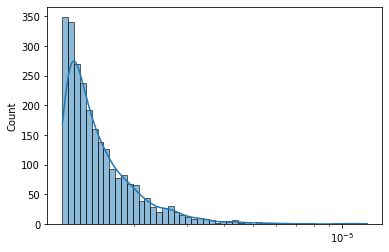

In [7]:
# grain radius distribution: n(s) = k*s^alpha

Ndust = 2500
alpha = -3.5

gr_0 = 1000 * 1e-6 # grain radius when beta=0.05
gr_1 = 1.15 * 1e-6 # grain radius when beta=0.5

s_array = np.geomspace(gr_1, gr_0, 200)
s_array_powerlaw = s_array**alpha
s_array_powerlaw_sum = np.sum(s_array_powerlaw)
p_array = s_array_powerlaw/s_array_powerlaw_sum # normalized probability

from numpy import random
# grain radius array
gr_array_fixed = random.choice(s_array, p=p_array, size=(Ndust))
log_gr_interval = np.log(s_array[1]) - np.log(s_array[0])
# real grain radius in random order
gr_array = [np.exp((np.log(i) + np.random.rand()*log_gr_interval)) for i in gr_array_fixed]
sns.histplot(data=gr_array, log_scale=True, kde=True)

In [8]:
# get beta

if k1 <= 0.43: luminosity = 3.827e+26 * (k1**2.3) # Watts
else: luminosity = 3.827e+26 * (k1**4) # 0.43<k1<2
    

def get_beta(gr):
    grain_radius = gr # grain radius in [m]
    density = 1000. # kg/m^3 = 1g/cc
    Q_pr = 1.
    beta = rebx.rad_calc_beta(sim.G, rf.params["c"], ps[0].m, luminosity, grain_radius, density, Q_pr)
    
    return beta

# print("beta = {0}".format(beta))

<AxesSubplot:ylabel='Count'>

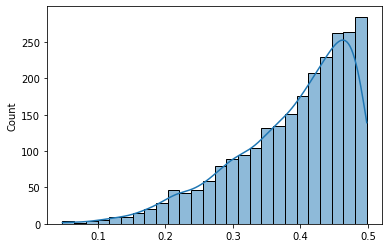

In [9]:
# get beta_array corresponding to gr_array
beta_array = [get_beta(i) for i in gr_array]
sns.histplot(data=beta_array, kde=True)

In [10]:
# obtain modified dust particle coords

a = 3*a_Planet
e = 0
incmax = 10 # [degree]
# s = np.sqrt(3) * 1e-3 * a_Planet

dust_coords = []
for i in range(2, Ndust+2):
#     a = amin + awidth*random.random() # Semimajor axis
    pomega = 2*np.pi*np.random.rand()   # Longitude of pericenter
    f = 2*np.pi*np.random.rand()        # True anomaly
    Omega = 2*np.pi*np.random.rand()    # Longitude of node
    inc = incmax*np.random.rand()       # Inclination
    
    sim.add(a=a, e=e, inc=inc*Degree_To_Rad, Omega=Omega, pomega=pomega, f=f) # fake add to obtain Cartesian coords
    beta = beta_array[i-2]
    xi, yi, zi = ps[2].x, ps[2].y, ps[2].z
    vxi, vyi, vzi = np.sqrt(1-beta)*ps[2].vx, np.sqrt(1-beta)*ps[2].vy, np.sqrt(1-beta)*ps[2].vz # modify vxyz for a circular orbit
    sim.remove(2)
    dust_coords.append([xi, yi, zi, vxi, vyi, vzi])
   

In [11]:
sim.status()

---------------------------------
REBOUND version:     	3.17.3
REBOUND built on:    	Jun 26 2021 14:35:07
Number of particles: 	2
Selected integrator: 	ias15
Simulation time:     	0.0000000000000000e+00
Current timestep:    	10.000000
---------------------------------
<rebound.particle.Particle object at 0x7f9b21346840, m=1.99e+30 x=-6629047.270492766 y=0.0 z=0.0 vx=0.0 vy=-131.71788839324768 vz=0.0>
<rebound.particle.Particle object at 0x7f9b21346a40, m=1.898e+27 x=6950370952.729507 y=0.0 z=0.0 vx=0.0 vy=138102.52787279393 vz=0.0>
---------------------------------


In [12]:
xs = [ps[i].x for i in range(sim.N)]
ys = [ps[i].y for i in range(sim.N)]
zs = [ps[i].z for i in range(sim.N)]

Text(0.5, 1.0, 'Edge-on view')

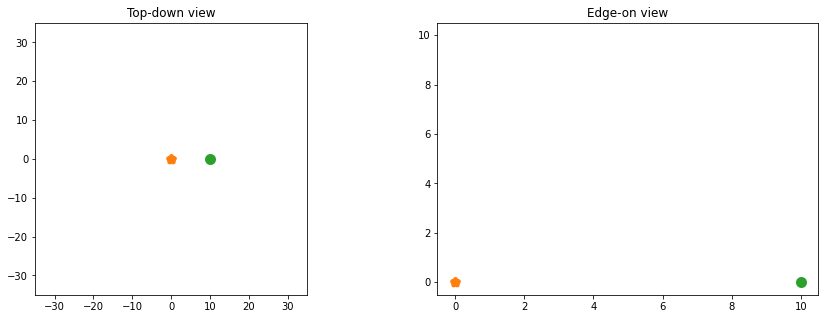

In [13]:
fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(15,5))
ax1.scatter(np.array(xs)/R_Sun, np.array(ys)/R_Sun)
ax1.scatter(ps[0].x/R_Sun, ps[0].y/R_Sun, marker = '*', linewidth = 5) # Star
ax1.scatter(ps[1].x/R_Sun, ps[1].y/R_Sun, marker = 'o', linewidth = 5) # Planet
ax1.set_xlim([-35, 35])
ax1.set_ylim([-35, 35])
ax1.set_aspect('equal')
ax1.set_title('Top-down view')
ax2.scatter(np.array(xs)/R_Sun, np.array(zs)/R_Sun)
ax2.scatter(ps[0].x/R_Sun, ps[0].z/R_Sun, marker = '*', linewidth = 5) # Star
ax2.scatter(ps[1].x/R_Sun, ps[1].z/R_Sun, marker = 'o', linewidth = 5) # Planet
ax2.set_ylim(ax2.get_xlim())
ax2.set_title('Edge-on view')

Start Integration
--

In [14]:
# pick out dusts that have been ejected out

# PE + KE wrt Star
def get_E(sim, ps_i):
    rstar = np.array(ps['Star'].xyz)
    r = np.array(ps_i.xyz)
    v = np.array(ps_i.vxyz)
    
    KE = 0.5 * v@v # test particle kinetic energy
    mu = sim.G * ps['Star'].m
    r_ds = r - rstar
    PE = -mu/np.sqrt(r_ds@r_ds) # test particle potential energy
    
    E = KE + PE
    
    return E

In [1]:
%%time

yr = 365*24*3600 # s

Noutput = Ndust
times = np.linspace(0, 5e2*yr, Noutput)

N_d, N_sub, N_pl, N_ej = np.zeros(Noutput), np.zeros(Noutput), np.zeros(Noutput), np.zeros(Noutput)


ps_ej = []
xyzs = []
vxyzs = []
grs = []

for i, time in enumerate(times):
    sim.integrate(time)
    
    N_d[i] = sim.N-2
    N_sub[i], N_pl[i], N_ej[i] = len(ps_sub), len(ps_pl), len(ps_ej)
    
    xyzs.append([ps[j].xyz for j in range(sim.N)])
    vxyzs.append([ps[j].vxyz for j in range(sim.N)])
    grs.append([ps[j].r for j in range(sim.N)])
    
    # add dust particles    
    hash_i = '{}'.format(i+2)
    dust_coords_i = dust_coords[i]
    sim.add(x=dust_coords_i[0],y=dust_coords_i[1], z=dust_coords_i[2],
            vx=dust_coords_i[3], vy=dust_coords_i[4], vz=dust_coords_i[5], r=gr_array[i], hash=hash_i)
    ps[hash_i].params["beta"] = beta_array[i]
    

    # ejection judgement
    E_ps_array = []
    for j in range(2, sim.N):
        E_ps_array.append(get_E(sim, ps[j]))
    
    index_ej = np.where(np.array(E_ps_array)>0)[0] + 2
    
    l = 0 # count of dusts already removed in this round
    for k in range(len(index_ej)):
        ps_ej.append(str(ps[int(index_ej[k])-l].hash))
        print ('Ejection:', str(ps[int(index_ej[k])-l].hash), 'at %.5f'%(sim.t/yr), '[yr]')
        sim.remove(int(index_ej[k])-l)
        l += 1


Sublimation: c_uint(1849110232) at 29.22996 [yr]
Sublimation: c_uint(2994598530) at 31.83637 [yr]
Sublimation: c_uint(2608811798) at 33.14277 [yr]
Sublimation: c_uint(2349907827) at 33.84641 [yr]
Sublimation: c_uint(2374753723) at 34.37724 [yr]
Hit the Planet: c_uint(1100653373) at 36.67390 [yr]
Sublimation: c_uint(2571035570) at 36.69307 [yr]
Hit the Planet: c_uint(1723803965) at 36.78108 [yr]
Ejection: c_uint(3594102755) at 37.21489 [yr]
Sublimation: c_uint(2713348148) at 37.23003 [yr]
Sublimation: c_uint(4271056542) at 37.27898 [yr]
Sublimation: c_uint(4045249981) at 37.99410 [yr]
Sublimation: c_uint(1053595590) at 38.50425 [yr]
Sublimation: c_uint(2665145213) at 38.79235 [yr]
Sublimation: c_uint(681087341) at 39.00352 [yr]
Sublimation: c_uint(1978157060) at 39.12655 [yr]
......
CPU times: user 1h 12min 8s, sys: 7.47 s, total: 1h 12min 15s
Wall time: 1h 12min 17s


In [16]:
print("Particles in the simulation at t=%5.1f : %d"%(sim.t/yr, sim.N))

Particles in the simulation at t=500.0 : 233


In [17]:
xs_f = [ps[i].x for i in range(sim.N)]
ys_f = [ps[i].y for i in range(sim.N)]
zs_f = [ps[i].z for i in range(sim.N)]
log_grs_f = [np.log10(ps[i].r) for i in range(sim.N)]

Text(0.5, 1.0, 'Edge-on view')

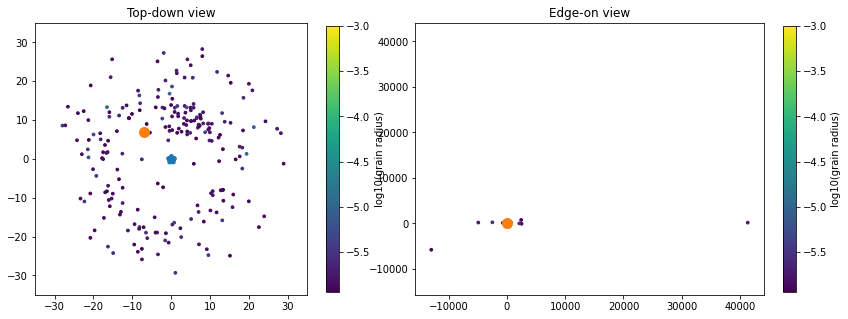

In [18]:
fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(15,5))
color_map = plt.cm.get_cmap('PuBuGn')
sctt1 = ax1.scatter(np.array(xs_f)/R_Sun, np.array(ys_f)/R_Sun, c=log_grs_f, s=30, marker = '.')
sctt1.set_clim(vmin=np.log10(gr_1), vmax=np.log10(gr_0))
fig.colorbar(sctt1, ax = ax1, fraction=0.035, pad=0.05, location = 'right').set_label('log10(grain radius)')
ax1.scatter(ps[0].x/R_Sun, ps[0].y/R_Sun, marker = '*', linewidth = 5) # Star
ax1.scatter(ps[1].x/R_Sun, ps[1].y/R_Sun, marker = 'o', linewidth = 5) # Planet
ax1.set_xlim([-35, 35])
ax1.set_ylim([-35, 35])
ax1.set_aspect('equal')
ax1.set_title('Top-down view')
sctt2 = ax2.scatter(np.array(xs_f)/R_Sun, np.array(zs_f)/R_Sun, c=log_grs_f, s=30, marker = '.')
sctt2.set_clim(vmin=np.log10(gr_1), vmax=np.log10(gr_0))
fig.colorbar(sctt2, ax = ax2, fraction=0.035, pad=0.05, location = 'right').set_label('log10(grain radius)')
ax2.scatter(ps[0].x/R_Sun, ps[0].z/R_Sun, marker = '*', linewidth = 5) # Star
ax2.scatter(ps[1].x/R_Sun, ps[1].z/R_Sun, marker = 'o', linewidth = 5) # Planet
ax2.set_ylim(ax2.get_xlim())
ax2.set_title('Edge-on view')

movie - inertial frame
--

In [19]:
xs_it = []
ys_it = []
zs_it = []
for i in range(len(xyzs)):
        xs_it.append([j[0] for j in xyzs[i]])
        ys_it.append([j[1] for j in xyzs[i]])
        zs_it.append([j[2] for j in xyzs[i]])

In [20]:
log_grs_it = []
for i in range(len(grs)):
        log_grs_it.append([np.log10(j) for j in grs[i]])


/Users/minliqiu/opt/anaconda3/lib/python3.8/site-packages/matplotlib/animation.py:973: UserWarning: Animation was deleted without rendering anything. This is most likely unintended. To prevent deletion, assign the Animation to a variable that exists for as long as you need the Animation.
  warnings.warn(


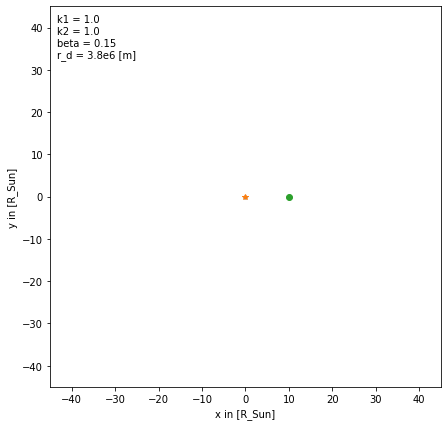

In [29]:
import matplotlib.animation as animation

fig = plt.figure(figsize=(7, 7))
ax = plt.subplot(111)
ax.set_xlim(-45, 45)
ax.set_ylim(-45, 45)
ax.set_xlabel('x in [R_Sun]')
ax.set_ylabel('y in [R_Sun]')


points, = ax.plot(np.array(xs_it[0])/R_Sun, np.array(ys_it[0])/R_Sun, '.', lw = 5)
points_s, = ax.plot(np.array(xs_it[0][0])/R_Sun, np.array(ys_it[0][0])/R_Sun, '*', lw=8)
points_p, = ax.plot(np.array(xs_it[0][1])/R_Sun, np.array(ys_it[0][1])/R_Sun, 'o', lw=8)

time_template = 'integration time = %.1fyr'
time_text = ax.text(0, 49, '', fontsize=16, ha='center')

para_template = ('N_d = {}')
para_text = ax.text(24.5, 41, '', fontsize=12)

sub_template = ('N_sub = {}')
sub_text = ax.text(24.5, 37.5, '', fontsize=12)

pl_template = ('N_pl = {}')
pl_text = ax.text(24.5, 34, '', fontsize=12)

ej_template = ('N_ej = {}')
ej_text = ax.text(24.5, 30.5, '', fontsize=12)

ax.text(-43.5, 30, 'k1 = 1.0\nk2 = 1.0\nbeta = 0.15\nr_d = 3.8e6 [m]\n')


def animate(i):
    points.set_data(np.array(xs_it[i])/R_Sun, np.array(ys_it[i])/R_Sun)
    points_s.set_data(np.array(xs_it[i][0])/R_Sun, np.array(ys_it[i][0])/R_Sun)
    points_p.set_data(np.array(xs_it[i][1])/R_Sun, np.array(ys_it[i][1])/R_Sun)
    time_text.set_text(time_template % (times[i]/yr))
    para_text.set_text(para_template.format(N_d[i]))
    sub_text.set_text(sub_template.format(N_sub[i]))
    pl_text.set_text(pl_template.format(N_pl[i]))
    ej_text.set_text(ej_template.format(N_ej[i]))
    return points, points_s, points_p, time_text, para_text
    
        
ani = animation.FuncAnimation(fig, animate, len(xyzs), interval=150) # len(xyzs)
# ani.save('animation_500yrs.mp4')
plt.show()


In [32]:
from IPython.display import HTML

HTML(ani.to_html5_video())

movie - rotating frame
--

In [26]:
phi = np.zeros(len(xs_it))
xs_rf = []
ys_rf = []
phis_rf = []
rs_rf = []
# spherical coords
r_sp_rf, phi_sp_rf, theta_sp_rf = [], [], []
for i in range(len(xs_it)):
    phi[i] = np.arctan2((ys_it[i][1]-ys_it[i][0]), (xs_it[i][1]-xs_it[i][0]))
    xs_rfj, ys_rfj = np.zeros(len(xs_it[i])), np.zeros(len(xs_it[i]))
    phis_rfj, rs_rfj = np.zeros(len(xs_it[i])), np.zeros(len(xs_it[i]))
    # spherical coords
    r_sp_rfj, phi_sp_rfj, theta_sp_rfj = np.zeros(len(xs_it[i])), np.zeros(len(xs_it[i])), np.zeros(len(xs_it[i]))
    for j in range(len(xs_it[i])):
        xs_rfj[j] = xs_it[i][j] * np.cos(phi[i]) + ys_it[i][j] * np.sin(phi[i])
        ys_rfj[j] = -xs_it[i][j] * np.sin(phi[i]) + ys_it[i][j] * np.cos(phi[i])
        phis_rfj[j] = np.arctan2(ys_rfj[j], xs_rfj[j])
        rs_rfj[j] = (xs_rfj[j]**2+ys_rfj[j]**2)**0.5
        # spherical coords
        r_sp_rfj[j] = np.sqrt(xs_rfj[j]**2 + ys_rfj[j]**2 + zs_it[i][j]**2)
        phi_sp_rfj[j] = phis_rfj[j]
        theta_sp_rfj[j] = np.arctan2(rs_rfj[j], zs_it[i][j])
    xs_rf.append(xs_rfj)
    ys_rf.append(ys_rfj)
    phis_rf.append(phis_rfj)
    rs_rf.append(rs_rfj)
    # spherical coords
    r_sp_rf.append(r_sp_rfj)
    phi_sp_rf.append(phi_sp_rfj)
    theta_sp_rf.append(theta_sp_rfj)


/Users/minliqiu/opt/anaconda3/lib/python3.8/site-packages/matplotlib/animation.py:973: UserWarning: Animation was deleted without rendering anything. This is most likely unintended. To prevent deletion, assign the Animation to a variable that exists for as long as you need the Animation.
  warnings.warn(


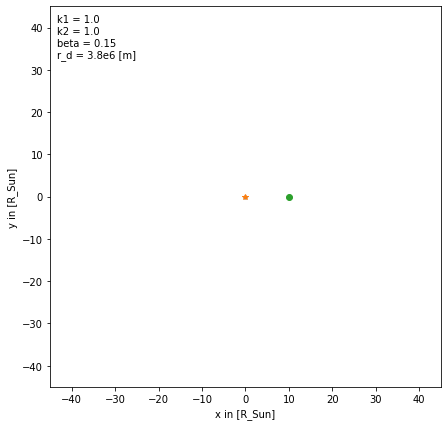

In [27]:
fig = plt.figure(figsize=(7, 7))
ax = plt.subplot(111)
ax.set_xlim(-45, 45)
ax.set_ylim(-45, 45)
ax.set_xlabel('x in [R_Sun]')
ax.set_ylabel('y in [R_Sun]')


points, = ax.plot(np.array(xs_rf[0])/R_Sun, np.array(ys_rf[0])/R_Sun, '.', lw = 5)
points_s, = ax.plot(np.array(xs_rf[0][0])/R_Sun, np.array(ys_rf[0][0])/R_Sun, '*', lw=8)
points_p, = ax.plot(np.array(xs_rf[0][1])/R_Sun, np.array(ys_rf[0][1])/R_Sun, 'o', lw=8)

time_template = 'integration time = %.1fyr'
time_text = ax.text(0, 49, '', fontsize=16, ha='center')

para_template = ('N_d = {}')
para_text = ax.text(24.8, 41, '', fontsize=12)

sub_template = ('N_sub = {}')
sub_text = ax.text(24.8, 37.5, '', fontsize=12)

pl_template = ('N_pl = {}')
pl_text = ax.text(24.8, 34, '', fontsize=12)

ej_template = ('N_ej = {}')
ej_text = ax.text(24.8, 30.5, '', fontsize=12)


ax.text(-43.5, 30, 'k1 = 1.0\nk2 = 1.0\nbeta = 0.15\nr_d = 3.8e6 [m]\n')


def animate(i):
    points.set_data(np.array(xs_rf[i])/R_Sun, np.array(ys_rf[i])/R_Sun)
    points_s.set_data(np.array(xs_rf[i][0])/R_Sun, np.array(ys_rf[i][0])/R_Sun)
    points_p.set_data(np.array(xs_rf[i][1])/R_Sun, np.array(ys_rf[i][1])/R_Sun)
    time_text.set_text(time_template % (times[i]/yr))
    para_text.set_text(para_template.format(N_d[i]))
    sub_text.set_text(sub_template.format(N_sub[i]))
    pl_text.set_text(pl_template.format(N_pl[i]))
    ej_text.set_text(ej_template.format(N_ej[i]))
    return points, points_s, points_p, time_text, para_text
    
        
ani = animation.FuncAnimation(fig, animate, len(xyzs), interval=150) # len(xyzs)
# ani.save('animation_rf_500yrs.mp4')
plt.show()


In [28]:
from IPython.display import HTML

HTML(ani.to_html5_video())

spherical grids in the rotating frame
--

In [33]:
j, k, l, m = 8, 8, 8, 8
r_cell = 35*R_Sun/j
phi_cell = 2*np.pi/k
theta_cell = np.pi/l
gr_cell = (gr_0 - gr_1)/m

r_grid = np.linspace(0, j, j+1)
phi_grid = np.linspace(0, k, k+1)
theta_grid = np.linspace(0, l, l+1)
gr_grid = np.linspace(0, m, m+1)

# center for each grid
r_center = np.linspace(0.5, j-0.5, j)
phi_center = np.linspace(0.5, k-0.5, k)
theta_center = np.linspace(0.5, l-0.5, l)
gr_center = np.linspace(0.5, m-0.5, m)



In [34]:
# find out which grid every dust particle falls in at each time step
n_r, n_theta, n_phi, n_gr = [], [], [], []
for i in range(len(r_sp_rf)):
    n_r.append([int(j) for j in (r_sp_rf[i]/r_cell)])
    n_theta.append([int(j) for j in ((theta_sp_rf[i]%(2*np.pi))/theta_cell)])
    n_phi.append([int(j) for j in ((phi_sp_rf[i]%(2*np.pi))/phi_cell)])
    n_gr.append([int(j) for j in ((np.array(grs[i])-gr_1)/gr_cell)])

In [35]:
# recombination to [r, theta, phi] coords
n_rthetaphi = []
for i in range(len(n_r)):
    trans = np.array([n_r[i], n_theta[i], n_phi[i]]).T
    n_rthetaphi.append(trans)


In [36]:
%%time
import itertools
n = []
n_s_distribution = []
# time iteration
for i in range(len(n_rthetaphi)):
    ni = []
    n_s_distribution_i = []
    for index in itertools.product(r_grid, theta_grid, phi_grid):
        list_ind = list(index)
        count = 0
        n_s_distribution_ij = []
        for j in range(len(n_rthetaphi[i])):
            if list_ind == list(n_rthetaphi[i][j]):
                count += 1
                n_s_distribution_ij.append(n_gr[i][j])
        list_ind.append(count)
        ni.append(list_ind)
        n_s_distribution_i.append(n_s_distribution_ij)
    n.append(ni)
    n_s_distribution.append(n_s_distribution_i)
    

CPU times: user 6min 28s, sys: 1.81 s, total: 6min 30s
Wall time: 6min 31s


In [37]:
n_trans = np.array(n[-1]).T
# same for all timepoints
r_center = (n_trans[0]+0.5)*r_cell/R_Sun
theta_center = (n_trans[1]+0.5)*theta_cell
phi_center = (n_trans[2]+0.5)*phi_cell

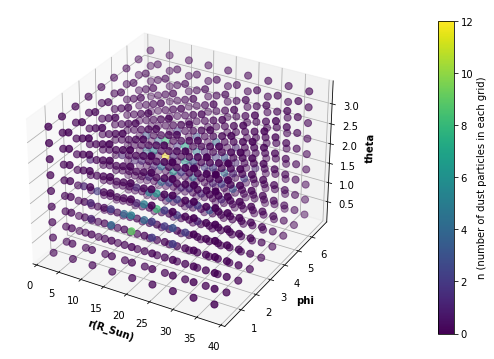

In [38]:
# final state - count
fig = plt.figure(figsize=(8, 8))
ax = fig.add_subplot(projection='3d')
ax.set_xlabel('r(R_Sun)', fontweight ='bold')
ax.set_ylabel('phi', fontweight ='bold')
ax.set_zlabel('theta', fontweight ='bold')

ax.set_xlim(0, 40)

color_map = plt.cm.get_cmap('PuBuGn')
sctt = ax.scatter(r_center, phi_center, theta_center, c=n_trans[3], s=200, marker = '.')
# plt.colorbar().set_label('MEGNO $\\langle Y \\rangle$')
fig.colorbar(sctt, ax = ax, fraction=0.035, pad=0.2, location = 'right').set_label('n (number of dust particles in each grid)')
# sctt.set_clim(vmin=0, vmax=15)
plt.show()

r-phi plane (sum over theta)
--

In [39]:
# recombination to [r, phi] coords
n_rphi = []
for i in range(len(n_r)):
    trans = np.array([n_r[i], n_phi[i]]).T
    n_rphi.append(trans)

In [40]:
%%time
import itertools
n_new = []
n_s_distribution_new = []
# time iteration
for i in range(len(n_rphi)):
    ni = []
    n_s_distribution_i = []
    for index in itertools.product(r_grid, phi_grid):
        list_ind = list(index)
        count = 0
        n_s_distribution_ij = []
        for j in range(len(n_rphi[i])):
            if list_ind == list(n_rphi[i][j]):
                count += 1
                n_s_distribution_ij.append(grs[i][j])
        list_ind.append(count)
        ni.append(list_ind)
        n_s_distribution_i.append(n_s_distribution_ij)
    n_new.append(ni)
    n_s_distribution_new.append(n_s_distribution_i)
    

CPU times: user 41.3 s, sys: 212 ms, total: 41.5 s
Wall time: 41.6 s


In [42]:
n_trans_new = np.array(n_new[-1]).T
# same for all timepoints
r_center_new = (n_trans_new[0]+0.5)*r_cell/R_Sun
phi_center_new = (n_trans_new[1]+0.5)*phi_cell

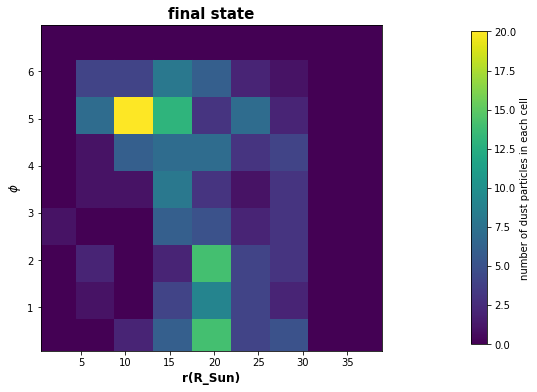

In [43]:
# final state - count
fig = plt.figure(figsize=(8,6))
ax = plt.subplot(111)
ax.set_title('final state', fontweight ='bold', fontsize=15)
ax.set_xlabel('r(R_Sun)', fontweight ='bold', fontsize=12)
ax.set_ylabel(r'$\phi$', fontweight ='bold', fontsize=12)

# ax.set_xlim(0, 40)
# ax.set_ylim(0, 6.5)

color_map = plt.cm.get_cmap('PuBuGn')
ax.scatter(r_center_new, phi_center_new, c=n_trans_new[2], s=1500, marker = ',')
# plt.colorbar().set_label('MEGNO $\\langle Y \\rangle$')
fig.colorbar(sctt, ax = ax, fraction=0.035, pad=0.2, location = 'right').set_label('number of dust particles in each cell')
sctt.set_clim(vmin=np.min(n_trans_new[2]), vmax=np.max(n_trans_new[2]))
plt.show()

add up coords & distribution over the last 100 yrs
--

In [44]:
# add up coords
xs_rf_addup_ = []
ys_rf_addup_ = []
zs_it_addup_ = []
for i in range(2000, 2500):
    xs_rf_addup_.append(xs_rf[i][2:]) # get rid of Star & Planet at every timepoint
    ys_rf_addup_.append(ys_rf[i][2:])
    zs_it_addup_.append(zs_it[i][2:])

xs_rf_addup = list(itertools.chain.from_iterable(xs_rf_addup_)) # flatten to 1d list
ys_rf_addup = list(itertools.chain.from_iterable(ys_rf_addup_))
zs_it_addup = list(itertools.chain.from_iterable(zs_it_addup_))

In [45]:
# add up spherical coords
r_sp_rf_addup_ = []
theta_sp_rf_addup_ = []
phi_sp_rf_addup_ = []

for i in range(2000, 2500):
    r_sp_rf_addup_.append(r_sp_rf[i][2:]) # get rid of Star & Planet at every timepoint
    theta_sp_rf_addup_.append(theta_sp_rf[i][2:])
    phi_sp_rf_addup_.append(phi_sp_rf[i][2:])
    
r_sp_rf_addup = list(itertools.chain.from_iterable(r_sp_rf_addup_)) # flatten to 1d list
theta_sp_rf_addup = list(itertools.chain.from_iterable(theta_sp_rf_addup_))
phi_sp_rf_addup = list(itertools.chain.from_iterable(phi_sp_rf_addup_))

In [46]:
# get velocity
vxs_it = []
vys_it = []
vzs_it = []
for i in range(len(xyzs)):
        vxs_it.append([j[0] for j in vxyzs[i]])
        vys_it.append([j[1] for j in vxyzs[i]])
        vzs_it.append([j[2] for j in vxyzs[i]])

In [47]:
# add up velocity
vxs_addup_ = []
vys_addup_ = []
vzs_addup_ = []
for i in range(2000, 2500):
    vxs_addup_.append(vxs_it[i][2:]) # get rid of Star & Planet at every timepoint
    vys_addup_.append(vys_it[i][2:])
    vzs_addup_.append(vzs_it[i][2:])

vxs_addup = list(itertools.chain.from_iterable(vxs_addup_)) # flatten to 1d list
vys_addup = list(itertools.chain.from_iterable(vys_addup_))
vzs_addup = list(itertools.chain.from_iterable(vzs_addup_))

In [48]:
grs_dust = []
for i in range(len(grs)):
    grs_dust.append(grs[i][2:]) # get rid of Star & Planet at every timepoint

# add up grs_dust
grs_dust_addup = list(itertools.chain.from_iterable(grs_dust[2000:2500])) # flatten to 1d list

In [49]:
# add up n_rphi grid number
n_rphi_addup_ = []
for i in range(len(grs)):
    n_rphi_addup_.append(n_rphi[i][2:]) # get rid of Star & Planet at every timepoint
    
n_rphi_addup = list(itertools.chain.from_iterable(n_rphi_addup_[2000:2500])) # flatten to 1d list

In [50]:
# add up distribution
l = len(n_s_distribution_new[0])
n_s_dis_addup = [] # add up distribution in every cell
for j in range(l):
    n_s_dis_j = []
    for i in range(2000, 2500):
        n_s_dis_j.append(n_s_distribution_new[i][j])
    flatten_n_s_dis_j = list(itertools.chain.from_iterable(n_s_dis_j)) # flatten to 1d list
    # get rid of Star & planet size
    position = np.where(np.array(flatten_n_s_dis_j)<1)[0]
    flatten_n_s_dis_j_new = np.array(flatten_n_s_dis_j)[position.astype(int)]
    n_s_dis_addup.append(flatten_n_s_dis_j_new)

In [66]:
# add up count in each cell
n_addup = [len(i) for i in n_s_dis_addup]
n_ave = np.array(n_addup)/500

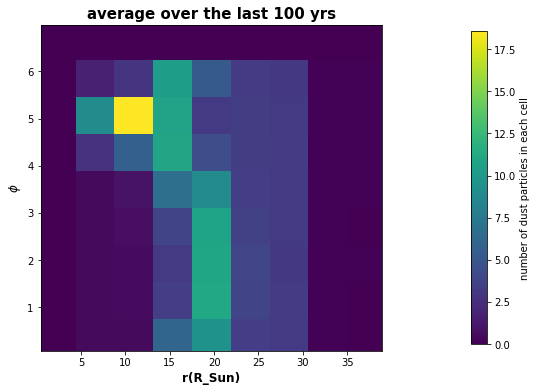

In [156]:
# addup distribution - count
fig = plt.figure(figsize=(8,6))
ax = plt.subplot(111)

ax.set_title('average over the last 100 yrs', fontweight ='bold', fontsize=15)
ax.set_xlabel('r(R_Sun)', fontweight ='bold', fontsize=12)
ax.set_ylabel(r'$\phi$', fontweight ='bold', fontsize=12)

# ax.set_xlim(0, 40)
# ax.set_ylim(0, 4)

color_map = plt.cm.get_cmap('PuBuGn')
ax.scatter(r_center_new, phi_center_new, c=n_ave, s=1500, marker = ',')
# plt.colorbar().set_label('MEGNO $\\langle Y \\rangle$')
fig.colorbar(sctt, ax = ax, fraction=0.035, pad=0.2, location = 'right').set_label('number of dust particles in each cell')
sctt.set_clim(vmin=np.min(n_ave), vmax=np.max(n_ave))
plt.show()

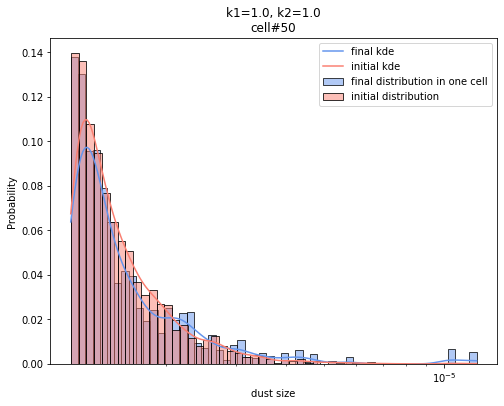

In [68]:
# pick up a random cell and see distribution
plt.figure(figsize=(8,6))
plt.title('k1=1.0, k2=1.0\ncell#50')
plt.xlabel('dust size')
sns.histplot(data=n_s_dis_addup[15], color='cornflowerblue', log_scale=True, kde=True, stat="probability")
sns.histplot(data=gr_array, color='salmon', log_scale=True, kde=True, stat="probability")
plt.legend(labels=["final kde", 'initial kde', 'final distribution in one cell', 'initial distribution'])

find closest pairs over the last 100 yrs
--

In [56]:
%%time
# find the closest particle
ind_close = []
gr_close = []
vxs_close, vys_close, vzs_close = [], [], []

for i in range(len(xs_rf_addup)):
    xs_diff, ys_diff, zs_diff = xs_rf_addup-xs_rf_addup[i], ys_rf_addup-ys_rf_addup[i], np.array(zs_it_addup)-zs_it_addup[i]
    d2 = xs_diff*xs_diff + ys_diff*ys_diff + zs_diff*zs_diff
    d2[i] = 10*max(d2) # rule out self.index
    # get the index of closest particle
    d2 = list(d2)
    min_ind = d2.index(min(d2))
    gr_close_i = grs_dust_addup[min_ind]
    vxs_close_i = vxs_addup[min_ind]
    vys_close_i = vys_addup[min_ind]
    vzs_close_i = vzs_addup[min_ind]
    # append
    ind_close.append(min_ind)
    gr_close.append(gr_close_i)
    vxs_close.append(vxs_close_i)
    vys_close.append(vys_close_i)
    vzs_close.append(vzs_close_i)


CPU times: user 54min 12s, sys: 5.46 s, total: 54min 18s
Wall time: 54min 19s


In [60]:
from sklearn.neighbors import KernelDensity

In [126]:
def get_n_close(n_s_dis_addup_i, gr_i):
    X = n_s_dis_addup_i[:,None]
    kde = KernelDensity(kernel='gaussian', bandwidth=1).fit(X)
    log_density = kde.score_samples(X)
    density = np.exp(log_density)
    position = np.where(n_s_dis_addup_i==gr_i)[0]
    print (density[position][0], len(n_s_dis_addup_i))
    n_close = density[position][0] * len(n_s_dis_addup_i)
    print (n_close)

    return n_close
    

In [133]:
# get n_close (number density of the closest particle) in each cell
ind_close_rphi = []
ind_close_cell = []
n_close_cell = [] # number
for i in range(len(ind_close)): 
    min_ind = ind_close[i]
    ind_close_rphii = n_rphi_addup[min_ind]
    ind_close_celli = 9*ind_close_rphii[0] + ind_close_rphii[1] # follow grid number
    if ind_close_celli < len(n_s_dis_addup):        
        n_close_celli = get_n_close(n_s_dis_addup_i=n_s_dis_addup[ind_close_celli], gr_i=gr_close[i])
    else:
        n_close_celli = 0
    # append
    ind_close_rphi.append(ind_close_rphii)
    ind_close_cell.append(ind_close_celli)
    n_close_cell.append(n_close_celli)

collision rate
--

In [134]:
n_close_cell_ave = np.array(n_close_cell)/500
v_cell = (4/3)*np.pi*(35*R_Sun)**3/81
n_close_cell_ave_v = n_close_cell_ave/v_cell

In [135]:
cross_section = np.pi * (np.array(grs_dust_addup)**2 + np.array(gr_close)**2)
v_rel = np.sqrt((np.array(vxs_addup)-np.array(vxs_close))**2 + (np.array(vys_addup)-np.array(vys_close))**2 + (np.array(vzs_addup)-np.array(vzs_close))**2)
gamma = n_close_cell_ave_v * cross_section * v_rel


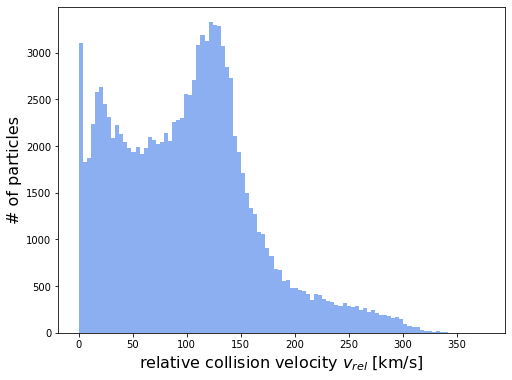

In [157]:
fig = plt.figure(figsize=(8,6))
ax = plt.subplot(111)
ax.set_xlabel(r'relative collision velocity $v_{rel}$ [km/s]' , fontsize=16) # fontweight ='bold'
ax.set_ylabel('# of particles', fontsize=16)
# ax.set_xlim(0, 10)
plt.hist(v_rel/1e3, bins=100, color='cornflowerblue', alpha=0.75)
plt.savefig('v_rel.pdf')

Accretion rate: $\dot M = w  \dot N \langle m \rangle = \frac{w \langle m \rangle}{T}$,
--

where $w$ is the weight, and $T$ is the average time interval between accreted dust particles.

Collision rate:  $\Gamma_i = w n_j \sigma v_{rel}$.
--

In [137]:
density = 1000. # kg/m^3
m_array = density * (4/3)*np.pi*np.array(gr_array)**3
m_ave = np.mean(m_array)

In [139]:
T = times[1] - times[0] # time interval

M_dot = m_ave/T # [kg/s]

print ('M_dot = {} [kg/s]'.format(M_dot))

M_dot = 5.492413134909147e-21 [kg/s]


In [150]:
M_dot_theory = 1e7/1e3 # [kg/s]

w = M_dot_theory/M_dot

print ('scaling coefficient: w = {}'.format(w))

scaling coefficient: w = 1.820693337222058e+24


In [152]:
# PR-drag timescale
c = 3.e8
a = 3*a_Planet
t_pr = c*(a**2)/(4*np.mean(beta_array)*sim.G * ps['Star'].m)

In [153]:
from numpy import ma

# gamma_new = w*gamma*yr
# Log_Gamma = ma.filled(np.log10(ma.masked_equal(gamma_new, 0)), -4)

gamma_t = w*gamma*t_pr
Log_Gamma_t = ma.filled(np.log10(ma.masked_equal(gamma_t, 0)), -4)


<ipython-input-153-ea9989abb98d>:7: RuntimeWarning: divide by zero encountered in log10
  Log_Gamma_t = ma.filled(np.log10(ma.masked_equal(gamma_t, 0)), -4)


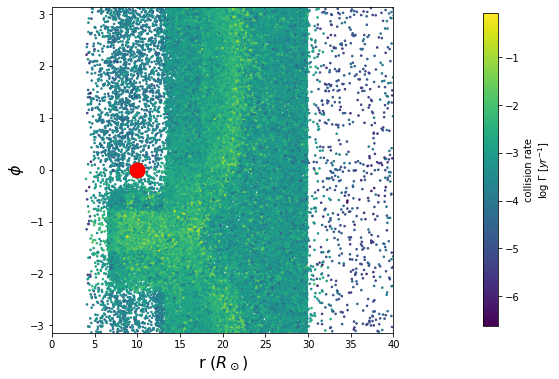

In [154]:
# final state - count
fig = plt.figure(figsize=(8,6))
ax = plt.subplot(111)

ax.set_xlabel(r'r ($R_\odot)$' , fontsize=16) # fontweight ='bold'
ax.set_ylabel(r'$\phi$', fontsize=16)

ax.set_xlim(0, 40)
ax.set_ylim(-np.pi, np.pi)

color_map = plt.cm.get_cmap('PuBuGn')
ax.scatter(np.array(r_sp_rf_addup)/R_Sun, phi_sp_rf_addup, c=Log_Gamma_t, s=10, marker = '.')
# plt.colorbar().set_label('MEGNO $\\langle Y \\rangle$')
fig.colorbar(sctt, ax = ax, fraction=0.035, pad=0.2, location = 'right').set_label('collision rate\n'r'log $\Gamma$ $[yr^{-1}]$')
sctt.set_clim(vmin=min(Log_Gamma_t), vmax=max(Log_Gamma_t))
# sctt.set_clim(vmin=0, vmax=1e-1)
ax.scatter(10, 0, marker="o", c='r', linewidth=10)



plt.show()